In [108]:
import cv2
import xml.etree.ElementTree as et
import matplotlib.patches as patches
import os
import zipfile
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm
import numpy as np
import albumentations as A
from albumentations.pytorch import ToTensorV2
import shutil
import torch  # PyTorch library
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from glob import glob
import random
from sklearn.model_selection import train_test_split


### Initializations


In [109]:
RANDOM_SEED = 42
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

BATCH_SIZE = 14

#Set to your path

DatasetPath = r"D:\FinalProject_ENSF619\Defects.zip"
train_file_path = r"D:\FinalProject_ENSF619\Defects\train"
valid_file_path = r"D:\FinalProject_ENSF619\Defects\valid"
test_file_path = r"D:\FinalProject_ENSF619\Defects\test"
%cd D:\FinalProject_ENSF619

D:\FinalProject_ENSF619


d:\FP_ENSF619\Lib\site-packages\IPython\core\magics\osm.py:417: UserWarning: using dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [110]:
# Class Labels and Mapping

class_names = [
    "background",
    "punching_hole",
    "welding_line",
    "crescent_gap",
    "water_spot",
    "oil_spot",
    "silk_spot",
    "inclusion",
    "rolled_pit",
    "crease",
    "waist_folding"
]

num_classes=len(class_names)
print(num_classes)

class_ids = [i for i in range(len(class_names))]

label2targets = {label: i for i, label in enumerate(class_names)}
targets2label = {i: label for i, label in enumerate(class_names)}

class_mapping = {
    '1_chongkong': 'punching_hole',
    '2_hanfeng': 'welding_line',
    '3_yueyawan': 'crescent_gap',
    '4_shuiban': 'water_spot',
    '5_youban': 'oil_spot',
    '6_siban': 'silk_spot',
    '7_yiwu': 'inclusion',
    '8_yahen': 'rolled_pit',
    '9_zhehen': 'crease',
    '10_yaozhe': 'waist_folding',
    '10_yaozhed': 'waist_folding'
}

class_ids, label2targets

11

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
 {'background': 0,
  'punching_hole': 1,
  'welding_line': 2,
  'crescent_gap': 3,
  'water_spot': 4,
  'oil_spot': 5,
  'silk_spot': 6,
  'inclusion': 7,
  'rolled_pit': 8,
  'crease': 9,
  'waist_folding': 10})

In [111]:
#Helper Functions to read and show image

def read_image(folder_id, image_id):
    image = cv2.imread(f'Defects/{folder_id}/{image_id}.jpg')
    tree = et.parse(f'Defects/lable/{image_id}.xml')
    root = tree.getroot()
    boxes = []
    labels = []
    for obj in root.findall('object'):
        name = obj.find('name').text
        xmin = float(obj.find('bndbox/xmin').text)
        ymin = float(obj.find('bndbox/ymin').text)
        xmax = float(obj.find('bndbox/xmax').text)
        ymax = float(obj.find('bndbox/ymax').text)
        boxes.append((xmin, ymin, xmax, ymax))
        labels.append(class_mapping[name])
    
    return image, boxes, labels
    
def show_image(image, boxes=None, labels=None, ax=None):
    if ax is None:
        fig, ax = plt.subplots(figsize=(10, 5))

    ax.imshow(image, cmap="gray")

    if boxes is not None and labels is not None:
        for box, label in zip(boxes, labels):
            x, y, xmax, ymax = box
            w = xmax - x
            h = ymax - y
            rect = patches.Rectangle((x, y), w, h, linewidth=1, edgecolor='r', facecolor='none')
            ax.add_patch(rect)
            ax.text(x, y, label, color='r', verticalalignment='bottom')

    ax.axis('off')
    if ax is None:
        plt.show()

In [112]:
# Send train=True fro training transforms and False for test transforms
def get_transform(train):    
    if train:
        return A.Compose([
            A.Resize(height=128, width=256),
            A.HorizontalFlip(p=0.5),
            A.VerticalFlip(p=0.5),
            A.ToFloat(),
            ToTensorV2(),
        ],
        bbox_params=A.BboxParams(format="pascal_voc", label_fields=['class_labels']))
    else:
        return  A.Compose([
            A.Resize(height=128, width=256),
            A.ToFloat(),
            ToTensorV2(),
        ],
        bbox_params=A.BboxParams(format="pascal_voc", label_fields=['class_labels']))

### Data loading - onetime


In [ ]:
# Extract Zip 
with zipfile.ZipFile(DatasetPath, 'r') as zip_ref:
    zip_ref.extractall('Defects')

In [ ]:
print(os.listdir('Defects'))

['1', '10', '2', '3', '4', '5', '6', '7', '8', '9', 'Defects Description.xlsx', 'lable', 'test', 'train', 'valid']


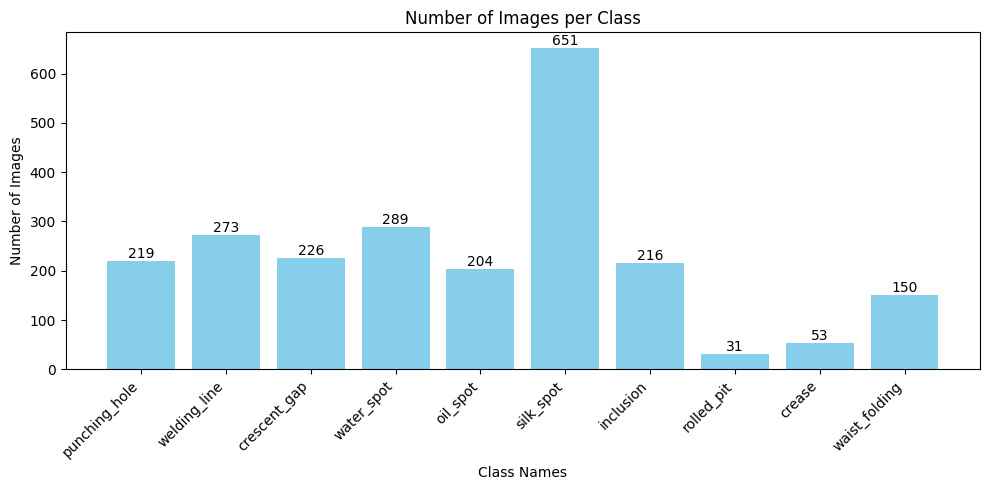

In [ ]:
# Display Bar Graph for number of images for each class

class_counts = {class_names[index]: len(os.listdir(f'Defects/{index}')) for index in range(1,len(class_names))}

plt.figure(figsize=(10, 5))
bars = plt.bar(class_counts.keys(), class_counts.values(), color='skyblue')
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height, f'{height}', ha='center', va='bottom')
plt.xticks(rotation=45, ha="right")
plt.title('Number of Images per Class')
plt.xlabel('Class Names')
plt.ylabel('Number of Images')
plt.tight_layout()  # Adjust layout to make room for the rotated x-axis labels
plt.show()

In [ ]:
object_names = {}
for file in os.listdir(f'Defects/lable'):
    tree = et.parse(f'Defects/lable/{file}')
    root = tree.getroot()
    for obj in root.findall('object'):
        if obj.find('name').text not in object_names:
            object_names[obj.find('name').text] = 1
        else:
            object_names[obj.find('name').text] += 1
        if obj.find('name').text == 'd':
            print(root.findall('path')[0].text)

print("The unique object names are: ", object_names)

# map classes
object_names['10_yaozhe'] = object_names['10_yaozhe'] + object_names['10_yaozhed']
del object_names['10_yaozhed']
#del object_names['d']

# map the keys of the object_names with class_map
object_names = {class_mapping[key]: value for key, value in object_names.items()}
print("The unique object names are: ", object_names)


The unique object names are:  {'3_yueyawan': 265, '9_zhehen': 74, '6_siban': 884, '4_shuiban': 354, '2_hanfeng': 513, '7_yiwu': 347, '5_youban': 569, '8_yahen': 85, '1_chongkong': 329, '10_yaozhe': 12, '10_yaozhed': 131}
The unique object names are:  {'crescent_gap': 265, 'crease': 74, 'silk_spot': 884, 'water_spot': 354, 'welding_line': 513, 'inclusion': 347, 'oil_spot': 569, 'rolled_pit': 85, 'punching_hole': 329, 'waist_folding': 143}


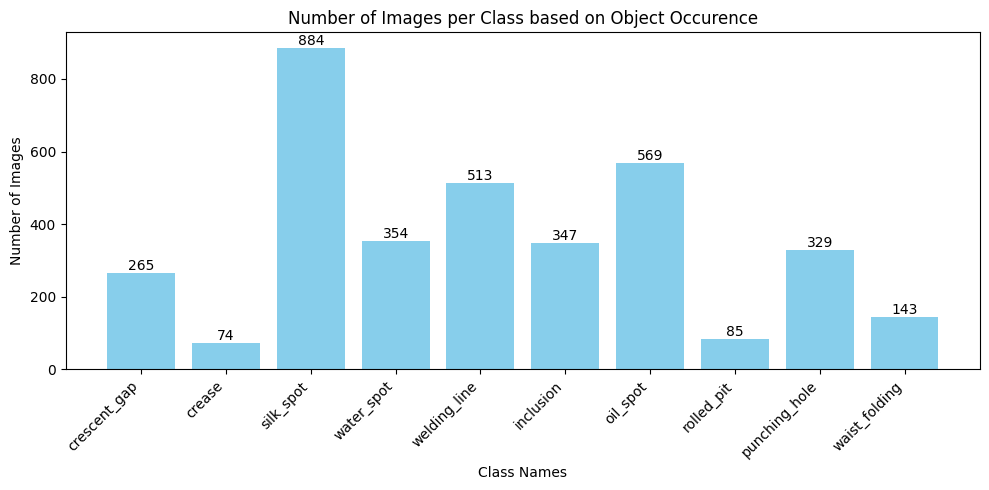

In [ ]:
# count based on the object occurence
plt.figure(figsize=(10, 5))
bars = plt.bar(object_names.keys(), object_names.values(), color='skyblue')
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height, f'{height}', ha='center', va='bottom')
plt.xticks(rotation=45, ha="right")
plt.title('Number of Images per Class based on Object Occurence')
plt.xlabel('Class Names')
plt.ylabel('Number of Images')
plt.tight_layout()  # Adjust layout to make room for the rotated x-axis labels
plt.show()

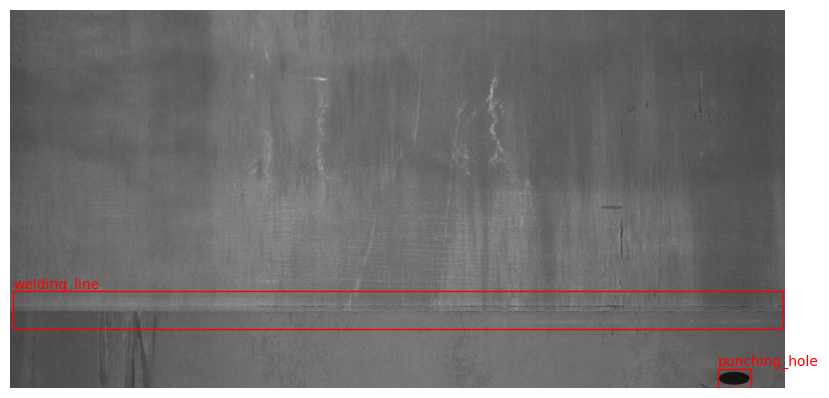

In [ ]:
# Sample image for visuallization

image_sample_id = "img_06_3403400500_00339"
image_sample_folder_id = 1

image, boxes, labels = read_image(image_sample_folder_id, image_sample_id)
show_image(image, boxes, labels)

torch.Size([3, 128, 256])


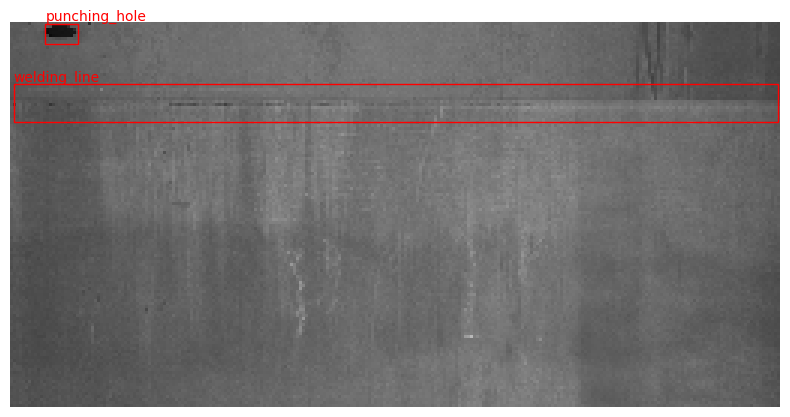

In [ ]:
transformed_image = get_transform(train=True)(image=image, bboxes=boxes, class_labels=labels)
print(transformed_image["image"].shape)
show_image(transformed_image["image"].permute(1, 2, 0), transformed_image["bboxes"], transformed_image["class_labels"])

Reading Data and making a dataframe of train, validate, and test datasets

In [ ]:
df = pd.DataFrame()

In [ ]:
for f in tqdm(os.listdir('Defects/lable')):
    tree = et.parse(f'Defects/lable/{f}')
    root = tree.getroot()
    path = root.find('path').text.split("\\")[-2:]
    # print(path) #['3', 'img_01_3402617700_00001.jpg']
    image_path = os.path.join('Defects', path[0], path[1])
    # image, boxes, labels = read_image(path[0], path[1].split(".")[0])
    # show_image(image, boxes, labels)
    for obj in root.findall('object'):
        name = obj.find('name').text
        if name in class_mapping:
            name = class_mapping[name]
            xmin = float(obj.find('bndbox/xmin').text)
            ymin = float(obj.find('bndbox/ymin').text)
            xmax = float(obj.find('bndbox/xmax').text)
            ymax = float(obj.find('bndbox/ymax').text)
            df = pd.concat([df, pd.DataFrame({'image_path': [image_path], 'class_name': [name], 'class_id': label2targets[name], 'xmin': [xmin], 'ymin': [ymin], 'xmax': [xmax], 'ymax': [ymax]})], ignore_index=True)
        else:
            print(f'Class {name} is not in the class_mapping')
            print(f'Path: {path}')

100%|██████████| 2294/2294 [00:01<00:00, 2291.07it/s]


In [ ]:
df.head()

,image_path,class_name,class_id,xmin,ymin,xmax,ymax
0,Defects\3\img_01_3402617700_00001.jpg,crescent_gap,3,1738.0,806.0,1948.0,993.0
1,Defects\3\img_01_3402617700_01009.jpg,crescent_gap,3,1756.0,298.0,1967.0,858.0
2,Defects\9\img_01_3436789500_00004.jpg,crease,9,981.0,182.0,2046.0,249.0
3,Defects\9\img_01_3436789500_00004.jpg,crease,9,478.0,179.0,711.0,244.0
4,Defects\6\img_01_3436814600_00259.jpg,silk_spot,6,746.0,17.0,1011.0,993.0


In [ ]:
print(len(df))

3563


In [ ]:
df = df.sample(frac=1).reset_index(drop=True)
train_df, temp_df = train_test_split(df, test_size=0.1, random_state=42, stratify=df['class_id'])
test_df, val_df = train_test_split(temp_df, test_size=0.5, random_state=42, stratify=temp_df['class_id'])

print(len(train_df), len(val_df), len(test_df))

3206 179 178


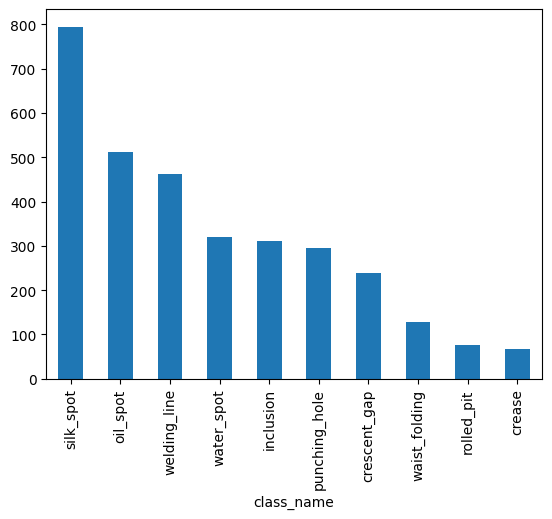

In [ ]:
train_df.class_name.value_counts().plot(kind='bar')
plt.show()

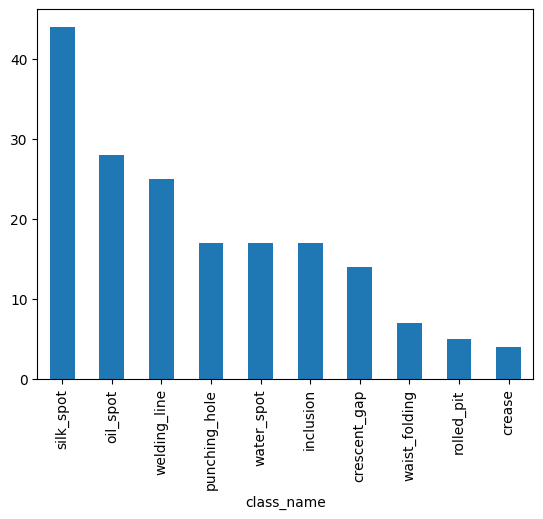

In [ ]:
test_df.class_name.value_counts().plot(kind='bar')
plt.show()

In [ ]:
!mkdir "Defects/train"
!mkdir "Defects/valid"
!mkdir "Defects/test"

In [ ]:
def add_data_to_folder(file_type, data):
    for index, row in data.iterrows():
        try:
            shutil.copy(row["image_path"], f'Defects/{file_type}')
        except Exception as e:
            print(f"Error copying {row['image_path']}", e)

In [ ]:
add_data_to_folder("train" , train_df)
add_data_to_folder("valid" , val_df)
add_data_to_folder("test" , test_df)

### Data Pre-processing


(1000, 2048, 3)
(1000, 2048, 3)


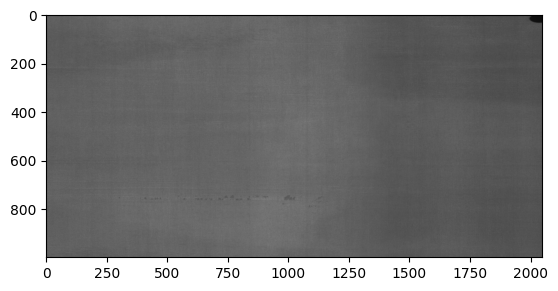

In [ ]:
sample_image_psth = r"D:\\FinalProject_ENSF619\Defects\\1\\img_02_425501900_00017.jpg"
image_cv2 = cv2.imread(sample_image_psth)
print(image_cv2.shape)

image = Image.open(sample_image_psth)
image = np.array(image)
image_np = np.stack((image,) * 3, axis=-1)
print(image_np.shape)

plt.imshow(image_cv2)

In [ ]:
class DefectsDataset(Dataset):
    def __init__(self, root, transform=None):
        self.img_paths = glob(os.path.join(root, '*.jpg'))
        random.shuffle(self.img_paths)
        self.transform = transform
    
    def __len__(self):
        return len(self.img_paths)
    
    def __getitem__(self, idx):
        # Load image and corresponding XML annotations
        img_path = self.img_paths[idx]
        xml_path = img_path.replace('.jpg', '.xml')
        xml_path = xml_path.replace('train', 'lable')
        xml_path = xml_path.replace('valid', 'lable')
        xml_path = xml_path.replace('test', 'lable')
             
        img = cv2.imread(img_path)

        xml_tree = et.parse(xml_path)
        objects = xml_tree.findall('object')
        
        labels = []
        boxes = []
        for obj in objects:
            # Extract label and bounding box coordinates from XML
            label = obj.find('name').text
            labels.append(label)
            xmin = float(obj.find('bndbox').find('xmin').text)
            ymin = float(obj.find('bndbox').find('ymin').text)
            xmax = float(obj.find('bndbox').find('xmax').text)
            ymax = float(obj.find('bndbox').find('ymax').text)
            box = [xmin, ymin, xmax, ymax]
            boxes.append(box)
        
        if self.transform:
            # Apply transformations
            transformed = self.transform(image=np.array(img), bboxes=boxes, class_labels=labels)
            img = transformed['image']
            boxes = transformed['bboxes']
            labels = transformed['class_labels']
            
        # # Prepare target dictionary
        boxes = torch.tensor(boxes).float()
        labels = torch.tensor([label2targets[class_mapping[label]] for label in labels]).long()
        target = {'labels': labels, 'boxes': boxes}

        return img, target

In [ ]:
train_ds = DefectsDataset(root=train_file_path, transform=get_transform(train=True))
valid_ds = DefectsDataset(root=valid_file_path, transform=get_transform(train=False))
test_ds = DefectsDataset(root=test_file_path, transform=get_transform(train=False))

print('The length of the training dataset = ', len(train_ds))
print('The length of the validation dataset = ', len(valid_ds))
print('The length of the test dataset = ', len(test_ds))

The length of the training dataset =  2129
The length of the validation dataset =  174
The length of the test dataset =  175


In [ ]:
def collate_fn(batch):
    return tuple(zip(*batch))

train_dl = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn)
val_dl = DataLoader(valid_ds, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn)
test_dl = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn)

Image shape =  torch.Size([3, 128, 256])
Labels =  tensor([4, 6])
Boxes =  tensor([[114.7500,   0.3840, 171.3750,  59.2640],
        [171.2500,  11.5200, 244.2500, 123.1360]])


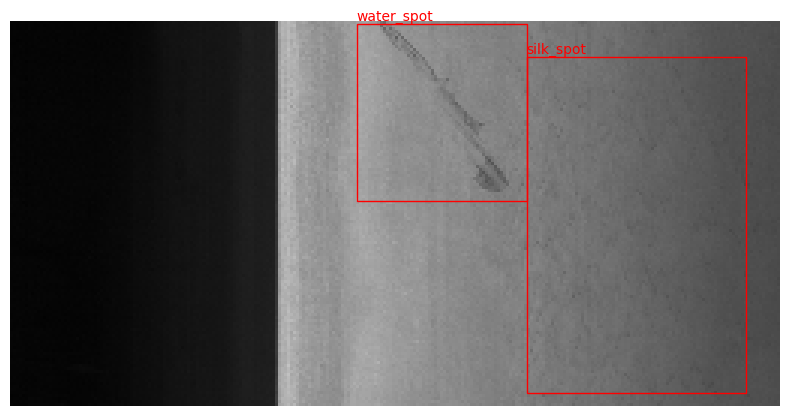

In [ ]:
# show one sample of train_ds
img, target = train_ds[60]
print('Image shape = ', img.shape)
print('Labels = ', target['labels'])
print('Boxes = ', target['boxes'])

# label2targets
labels = [targets2label[i.item()] for i in target['labels']]

show_image(img.permute(1, 2, 0), target['boxes'], labels)

Image shape =  torch.Size([3, 128, 256])
Image shape =  torch.Size([3, 128, 256])
Image shape =  torch.Size([3, 128, 256])
Image shape =  torch.Size([3, 128, 256])
Image shape =  torch.Size([3, 128, 256])
Image shape =  torch.Size([3, 128, 256])
Image shape =  torch.Size([3, 128, 256])
Image shape =  torch.Size([3, 128, 256])
Image shape =  torch.Size([3, 128, 256])
Image shape =  torch.Size([3, 128, 256])
Image shape =  torch.Size([3, 128, 256])
Image shape =  torch.Size([3, 128, 256])
Image shape =  torch.Size([3, 128, 256])
Image shape =  torch.Size([3, 128, 256])


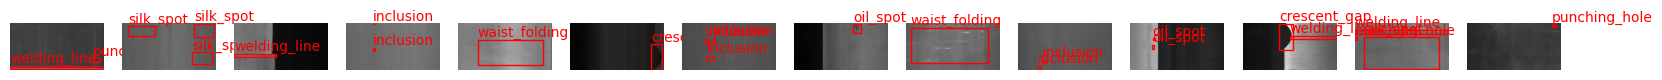

In [ ]:
for images, targets in train_dl:
    fig, axs = plt.subplots(1, BATCH_SIZE, figsize=(20, 10))
    for i in range(BATCH_SIZE):
        img = images[i]
        print('Image shape = ', img.shape)
        target = targets[i]
        labels = [targets2label[i.item()] for i in target['labels']]
        show_image(img.permute(1, 2, 0), target['boxes'], labels, axs[i])
    break

### Deep Learning Model


In [ ]:
from collections import OrderedDict
from typing import Callable, Dict, List, Optional, Tuple
import pickle
from torch_snippets import *

import torch.nn.functional as F
from torch import nn, Tensor

from torchvision.ops.misc import Conv2dNormActivation

from torchvision.models.detection import FasterRCNN
from torchvision.models import ResNet18_Weights
from torchvision.models.detection.backbone_utils import resnet_fpn_backbone
from torchvision.ops.feature_pyramid_network import ExtraFPNBlock
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

In [ ]:
class PathAggregationNetwork(ExtraFPNBlock):
    """
    Module that adds a PANet on set of FPN feature maps. This is based on 
    Path Aggregation Network for Instance Segmentation.
    """

    def __init__(self, out_channels: int, num_maps: int):
        super().__init__()
        self.down_sample_blocks = nn.ModuleList()
        self.panet_blocks = nn.ModuleList()

        for idx in range(num_maps):
            down_sample_module = Conv2dNormActivation(out_channels, out_channels, kernel_size = 3, stride = 2, padding = 1, norm_layer = None, inplace = False)
            panet_module = Conv2dNormActivation(out_channels, out_channels, kernel_size = 3, padding = 1,  norm_layer = None, inplace = False)
            self.down_sample_blocks.append(down_sample_module)
            self.panet_blocks.append(panet_module)
            

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_uniform_(m.weight, a=1)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)


    def get_results_from_down_sample_block(self, x: Tensor, idx: int) -> Tensor:
        """ 
        This is equivalent to self.down_sample_blocks[idx](x)
        """
        num_blocks = len(self.down_sample_blocks)
        if idx < 0:
            idx += num_blocks
        out = x
        for i, module in enumerate(self.down_sample_blocks):
            if i == idx:
                out = module(x)
        return out

    def get_results_from_panet_blocks(self, x: Tensor, idx: int):
        """
        This is equivalent to self.panet_blocks[idx](x)
        """
        num_blocks = len(self.panet_blocks)
        if idx < 0:
            idx += num_blocks
        out = x
        for i, module in enumerate(self.panet_blocks):
            if i == idx:
                out = module(x)
        return out         

    def forward(
        self, 
        results: List[Tensor],
        orignal: List[Tensor], 
        names: List[str],
    ) -> Tuple[List[Tensor], List[str]]:

        # unpack OrderedDict into two lists for easier handling
        n_panet = names
        x_panet = results
    
        results_panet = []
        results_panet.append(x_panet[0])
    
        for idx in range(1, len(x_panet)):
            feat_shape =  x_panet[idx].shape[-2:]
            down_sample_panet = self.get_results_from_down_sample_block(results_panet[idx-1], idx-1)
            down_sample_panet = F.interpolate(down_sample_panet, size = feat_shape, mode="nearest")
            fused_panet = down_sample_panet + x_panet[idx]
            layer_panet = self.get_results_from_panet_blocks(fused_panet, idx)
            results_panet.append(layer_panet)

        n_panet.append("pool")
        results_panet.append(F.max_pool2d(results_panet[-1], kernel_size = 1, stride = 2, padding = 0))

        return results_panet, n_panet


In [ ]:
# Initialize ResNet-FPN backbone
backbone = resnet_fpn_backbone(backbone_name='resnet18', weights=ResNet18_Weights.DEFAULT, trainable_layers=3, extra_blocks=PathAggregationNetwork(256, 4))
backbone.out_channels = 256
# print(backbone)

# Define input tensor (replace this with your actual input tensor)
input_tensor = torch.randn(1, 3, 128, 256)

# Pass input tensor through the backbone
output_tensor = backbone(input_tensor)

# Print the output tensor shape
print([(k, v.shape) for k, v in output_tensor.items()])

[
    ('0', torch.Size([1, 256, 32, 64])),
    ('1', torch.Size([1, 256, 16, 32])),
    ('2', torch.Size([1, 256, 8, 16])),
    ('3', torch.Size([1, 256, 4, 8])),
    ('pool', torch.Size([1, 256, 2, 4]))
]

In [ ]:
model = FasterRCNN(backbone=backbone, num_classes=num_classes)
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
print(model)

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=1e-05)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=1e-05)
          (relu): ReLU(inplace=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=1e-05)
        )
        (1): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=1e-05)
          (relu): ReLU(inplace=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=1e-05)
        )
      )
      (layer2): Sequential(
        (0): BasicBlock(
          (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(128, eps=1e-05)
          (relu): ReLU(inplace=True)
          (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(128, eps=1e-05)
          (downsample): Sequential(
            (0): Conv2d(64, 128, kernel_size=(1, 1), stride=(2, 2), bias=False)
            (1): FrozenBatchNorm2d(128, eps=1e-05)
          )
        )
        (1): BasicBlock(
          (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(128, eps=1e-05)
          (relu): ReLU(inplace=True)
          (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(128, eps=1e-05)
        )
      )
      (layer3): Sequential(
        (0): BasicBlock(
          (conv1): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(256, eps=1e-05)
          (relu): ReLU(inplace=True)
          (conv2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(256, eps=1e-05)
          (downsample): Sequential(
            (0): Conv2d(128, 256, kernel_size=(1, 1), stride=(2, 2), bias=False)
            (1): FrozenBatchNorm2d(256, eps=1e-05)
          )
        )
        (1): BasicBlock(
          (conv1): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(256, eps=1e-05)
          (relu): ReLU(inplace=True)
          (conv2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(256, eps=1e-05)
        )
      )
      (layer4): Sequential(
        (0): BasicBlock(
          (conv1): Conv2d(256, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(512, eps=1e-05)
          (relu): ReLU(inplace=True)
          (conv2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(512, eps=1e-05)
          (downsample): Sequential(
            (0): Conv2d(256, 512, kernel_size=(1, 1), stride=(2, 2), bias=False)
            (1): FrozenBatchNorm2d(512, eps=1e-05)
          )
        )
        (1): BasicBlock(
          (conv1): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(512, eps=1e-05)
          (relu): ReLU(inplace=True)
 

In [ ]:
# print summary of the model
def print_model_summary(model):
    print("Model Summary:")
    total_params = 0
    for name, parameter in model.named_parameters():
        param = parameter.numel()
        total_params+=param
        print(f"{name}, shape: {parameter.shape}, parameters: {param}")
    print(f"\nTotal trainable parameters: {total_params}")

print_model_summary(model)

Model Summary:

backbone.body.conv1.weight, shape: torch.Size([64, 3, 7, 7]), parameters: 9408

backbone.body.layer1.0.conv1.weight, shape: torch.Size([64, 64, 3, 3]), parameters: 36864

backbone.body.layer1.0.conv2.weight, shape: torch.Size([64, 64, 3, 3]), parameters: 36864

backbone.body.layer1.1.conv1.weight, shape: torch.Size([64, 64, 3, 3]), parameters: 36864

backbone.body.layer1.1.conv2.weight, shape: torch.Size([64, 64, 3, 3]), parameters: 36864

backbone.body.layer2.0.conv1.weight, shape: torch.Size([128, 64, 3, 3]), parameters: 73728

backbone.body.layer2.0.conv2.weight, shape: torch.Size([128, 128, 3, 3]), parameters: 147456

backbone.body.layer2.0.downsample.0.weight, shape: torch.Size([128, 64, 1, 1]), parameters: 8192

backbone.body.layer2.1.conv1.weight, shape: torch.Size([128, 128, 3, 3]), parameters: 147456

backbone.body.layer2.1.conv2.weight, shape: torch.Size([128, 128, 3, 3]), parameters: 147456

backbone.body.layer3.0.conv1.weight, shape: torch.Size([256, 128, 3, 3]), parameters: 294912

backbone.body.layer3.0.conv2.weight, shape: torch.Size([256, 256, 3, 3]), parameters: 589824

backbone.body.layer3.0.downsample.0.weight, shape: torch.Size([256, 128, 1, 1]), parameters: 32768

backbone.body.layer3.1.conv1.weight, shape: torch.Size([256, 256, 3, 3]), parameters: 589824

backbone.body.layer3.1.conv2.weight, shape: torch.Size([256, 256, 3, 3]), parameters: 589824

backbone.body.layer4.0.conv1.weight, shape: torch.Size([512, 256, 3, 3]), parameters: 1179648

backbone.body.layer4.0.conv2.weight, shape: torch.Size([512, 512, 3, 3]), parameters: 2359296

backbone.body.layer4.0.downsample.0.weight, shape: torch.Size([512, 256, 1, 1]), parameters: 131072

backbone.body.layer4.1.conv1.weight, shape: torch.Size([512, 512, 3, 3]), parameters: 2359296

backbone.body.layer4.1.conv2.weight, shape: torch.Size([512, 512, 3, 3]), parameters: 2359296

backbone.fpn.inner_blocks.0.0.weight, shape: torch.Size([256, 64, 1, 1]), parameters: 16384

backbone.fpn.inner_blocks.0.0.bias, shape: torch.Size([256]), parameters: 256

backbone.fpn.inner_blocks.1.0.weight, shape: torch.Size([256, 128, 1, 1]), parameters: 32768

backbone.fpn.inner_blocks.1.0.bias, shape: torch.Size([256]), parameters: 256

backbone.fpn.inner_blocks.2.0.weight, shape: torch.Size([256, 256, 1, 1]), parameters: 65536

backbone.fpn.inner_blocks.2.0.bias, shape: torch.Size([256]), parameters: 256

backbone.fpn.inner_blocks.3.0.weight, shape: torch.Size([256, 512, 1, 1]), parameters: 131072

backbone.fpn.inner_blocks.3.0.bias, shape: torch.Size([256]), parameters: 256

backbone.fpn.layer_blocks.0.0.weight, shape: torch.Size([256, 256, 3, 3]), parameters: 589824

backbone.fpn.layer_blocks.0.0.bias, shape: torch.Size([256]), parameters: 256

backbone.fpn.layer_blocks.1.0.weight, shape: torch.Size([256, 256, 3, 3]), parameters: 589824

backbone.fpn.layer_blocks.1.0.bias, shape: torch.Size([256]), parameters: 256

backbone.fpn.layer_blocks.2.0.weight, shape: torch.Size([256, 256, 3, 3]), parameters: 589824

backbone.fpn.layer_blocks.2.0.bias, shape: torch.Size([256]), parameters: 256

backbone.fpn.layer_blocks.3.0.weight, shape: torch.Size([256, 256, 3, 3]), parameters: 589824

backbone.fpn.layer_blocks.3.0.bias, shape: torch.Size([256]), parameters: 256

backbone.fpn.extra_blocks.down_sample_blocks.0.0.weight, shape: torch.Size([256, 256, 3, 3]), parameters: 589824

backbone.fpn.extra_blocks.down_sample_blocks.0.0.bias, shape: torch.Size([256]), parameters: 256

backbone.fpn.extra_blocks.down_sample_blocks.1.0.weight, shape: torch.Size([256, 256, 3, 3]), parameters: 589824

backbone.fpn.extra_blocks.down_sample_blocks.1.0.bias, shape: torch.Size([256]), parameters: 256

backbone.fpn.extra_blocks.down_sample_blocks.2.0.weight, shape: torch.Size([256, 256, 3, 3]), parameters: 589824

backbone.fpn.extra_blocks.down_sample_blocks.2.0.bias, shape: torch.Size([256]), parameters: 256

backbone.fpn.extra_blocks.down_sample_blocks.3.0.weight, shape: torch.Size([256, 256, 3, 3]), parameters: 589824

backbone.fpn.extra_blocks.down_sample_blocks.3.0.bias, shape: torch.Size([256]), parameters: 256

backbone.fpn.extra_blocks.panet_blocks.0.0.weight, shape: torch.Size([256, 256, 3, 3]), parameters: 589824

backbone.fpn.extra_blocks.panet_blocks.0.0.bias, shape: torch.Size([256]), parameters: 256

backbone.fpn.extra_blocks.panet_blocks.1.0.weight, shape: torch.Size([256, 256, 3, 3]), parameters: 589824

backbone.fpn.extra_blocks.panet_blocks.1.0.bias, shape: torch.Size([256]), parameters: 256

backbone.fpn.extra_blocks.panet_blocks.2.0.weight, shape: torch.Size([256, 256, 3, 3]), parameters: 589824

backbone.fpn.extra_blocks.panet_blocks.2.0.bias, shape: torch.Size([256]), parameters: 256

backbone.fpn.extra_blocks.panet_blocks.3.0.weight, shape: torch.Size([256, 256, 3, 3]), parameters: 589824

backbone.fpn.extra_blocks.panet_blocks.3.0.bias, shape: torch.Size([256]), parameters: 256

rpn.head.conv.0.0.weight, shape: torch.Size([256, 256, 3, 3]), parameters: 589824

rpn.head.conv.0.0.bias, shape: torch.Size([256]), parameters: 256

rpn.head.cls_logits.weight, shape: torch.Size([3, 256, 1, 1]), parameters: 768

rpn.head.cls_logits.bias, shape: torch.Size([3]), parameters: 3

rpn.head.bbox_pred.weight, shape: torch.Size([12, 256, 1, 1]), parameters: 3072

rpn.head.bbox_pred.bias, shape: torch.Size([12]), parameters: 12

roi_heads.box_head.fc6.weight, shape: torch.Size([1024, 12544]), parameters: 12845056

roi_heads.box_head.fc6.bias, shape: torch.Size([1024]), parameters: 1024

roi_heads.box_head.fc7.weight, shape: torch.Size([1024, 1024]), parameters: 1048576

roi_heads.box_head.fc7.bias, shape: torch.Size([1024]), parameters: 1024

roi_heads.box_predictor.cls_score.weight, shape: torch.Size([11, 1024]), parameters: 11264

roi_heads.box_predictor.cls_score.bias, shape: torch.Size([11]), parameters: 11

roi_heads.box_predictor.bbox_pred.weight, shape: torch.Size([44, 1024]), parameters: 45056

roi_heads.box_predictor.bbox_pred.bias, shape: torch.Size([44]), parameters: 44

Total trainable parameters: 33040646

In [ ]:
#print the number of trainable parameters
params = [p for p in model.parameters() if p.requires_grad]
print('The number of trainable parameters:', sum([p.numel() for p in model.parameters() if p.requires_grad]))

The number of trainable parameters: 32883782

Boxes:  tensor([], size=(0, 4), grad_fn=<IndexBackward0>)

Labels:  tensor([], dtype=torch.int64)

Scores:  tensor([], grad_fn=<IndexBackward0>)

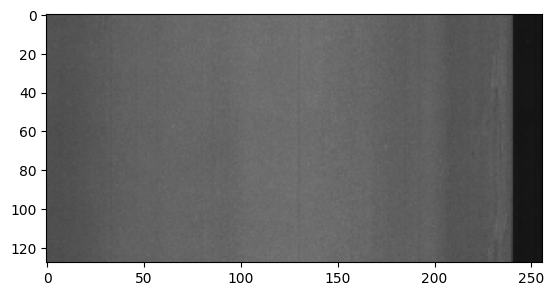

In [ ]:
# Set the model to evaluation mode to test its working
model.eval()

# Function to perform inference on an image tensor
def detect_objects(image_tensor, threshold=0.5):
    predictions = model([image_tensor])
    
    boxes = predictions[0]['boxes']
    labels = predictions[0]['labels']
    scores = predictions[0]['scores']
    
    # Filter out detections with score lower than threshold
    filtered_indices = scores > threshold
    boxes = boxes[filtered_indices]
    labels = labels[filtered_indices]
    scores = scores[filtered_indices]
    
    return boxes, labels, scores

# Function to draw bounding boxes on an image tensor
def draw_boxes(image_tensor, boxes, labels, scores):
    fig, ax = plt.subplots(1)
    ax.imshow(image_tensor.permute(1, 2, 0))  # Convert tensor from CxHxW to HxWxC for Matplotlib
    
    for box, label, score in zip(boxes, labels, scores):
        xmin, ymin, xmax, ymax = box.tolist()
        rect = patches.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin, linewidth=1, edgecolor='r', facecolor='none')
        ax.add_patch(rect)
        ax.text(xmin, ymin, f"{label}: {score:.2f}", color='r', fontsize=8, ha='left', va='top')
    
    plt.show()

# Example usage
image_tensor, target = train_ds[10]  # Assuming dataset is defined
boxes, labels, scores = detect_objects(image_tensor)
print("Boxes: ", boxes)
print("Labels: ", labels)
print("Scores: ", scores)
draw_boxes(image_tensor, boxes, labels, scores)

### Training the Model


In [ ]:
def calculate_iou(box1, box2):
    # Calculate intersection coordinates
    x1 = max(box1[0], box2[0])
    y1 = max(box1[1], box2[1])
    x2 = min(box1[2], box2[2])
    y2 = min(box1[3], box2[3])
    
    # Calculate intersection area
    intersection_area = max(0, x2 - x1) * max(0, y2 - y1)
    
    # Calculate union area
    box1_area = (box1[2] - box1[0]) * (box1[3] - box1[1])
    box2_area = (box2[2] - box2[0]) * (box2[3] - box2[1])
    union_area = box1_area + box2_area - intersection_area
    
    # Calculate IoU
    iou = intersection_area / union_area

    if iou>0.6:
        return True
    
    return False
    
def is_prediction_correct(prediction, target):
    """
    Check if the prediction matches the target.

    Args:
    prediction (dict): Predicted bounding boxes and labels.
    target (dict): Target bounding boxes and labels.

    Returns:
    correct (bool): True if the prediction is correct, False otherwise.
    """
    pred_boxes = prediction['boxes']
    pred_labels = prediction['labels']
    pred_scores = prediction['scores']
    target_boxes = target['boxes']
    target_labels = target['labels']

    # Find the predicted bounding box with the highest score for each class label
    pred_boxes_by_label = {}
    for box, label, score in zip(pred_boxes, pred_labels, pred_scores):
        if label not in pred_boxes_by_label or score > pred_boxes_by_label[label]['score']:
            pred_boxes_by_label[label] = {'box': box, 'score': score}

    # Check if the predicted bounding box with the highest score matches any of the target bounding boxes with the same class label
    for label, pred_box_info in pred_boxes_by_label.items():
        pred_box = pred_box_info['box']
        pred_score = pred_box_info['score']
        for target_box, target_label in zip(target_boxes, target_labels):
            if target_label == label and calculate_iou(pred_box, target_box):
                return True

    return False

# Example usage:
prediction = {'boxes': [(100, 100, 200, 200)], 'labels': [1], 'scores': [0.9]}  # Example prediction
target = {'boxes': [(90, 90, 210, 210)], 'labels': [1]}  # Example target
correct = is_prediction_correct(prediction, target)
print("Prediction Correct:", correct)

Prediction Correct: True

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001,
                      momentum=0.9, weight_decay=5e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200)

model = model.to(device).float()

In [ ]:
def train_batch(batch, model, optimizer, device):
    model.train()
    imgs, targets = batch
    imgs = list(img.to(device).float() for img in imgs)
    targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
    optimizer.zero_grad()
    losses = model(imgs, targets)
    loss = sum(loss for loss in losses.values())
    loss.backward()
    optimizer.step()
    return loss, losses

@torch.no_grad()
def validate_batch(batch, model, device):
    model.train()
    imgs, targets = batch
    imgs = list(img.to(device).float() for img in imgs)
    targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
    
    losses = model(imgs, targets)
    loss = sum(loss for loss in losses.values())

    model.eval()
    predictions = model(imgs)
    correct, total = 0, 0
    for prediction, target in zip(predictions, targets):
        correct += is_prediction_correct(prediction, target)
        total += 1
    return loss, losses


In [ ]:
def saveModel(log, modelState):
    # Save model
    torch.save(modelState, r"D:\FinalProject_ENSF619\Checkpoints-v3\ckpt "+str(e)+".pth")
    
    # Save the log report using pickle
    with open(r"D:\FinalProject_ENSF619\Checkpoints-v3\log_report "+str(e)+".pkl", 'wb') as f:
        pickle.dump(log, f)

In [ ]:
n_epochs = 200
log = Report(n_epochs)

In [ ]:
correct, total = 0, 0

for e in range(0, n_epochs): 
    correct, total = 0, 0       
    for i, batch in enumerate(train_dl):
        N = len(train_dl)
        loss, losses = train_batch(batch, model, optimizer, device)
        loc_loss, regr_loss, loss_objectness, loss_rpn_box_reg = [losses[k] for k in 
                                                                  ['loss_classifier', 'loss_box_reg', 'loss_objectness', 'loss_rpn_box_reg']]
        log.record(e + (i+1)/N, trn_loss=loss.item(), trn_loc_loss=loc_loss.item(),
                   trn_regr_loss=regr_loss.item(), trn_loss_objectness=loss_objectness.item(),
                   trn_loss_rpn_box_reg = loss_rpn_box_reg.item(),end="\r")
        
    for i, batch in enumerate(val_dl):
        N = len(val_dl)
        loss, losses, correct_, total_ = validate_batch(batch, model, device)
        
        loc_loss, regr_loss, loss_objectness, loss_rpn_box_reg = [losses[k] for k in 
                                                                  ['loss_classifier', 'loss_box_reg', 'loss_objectness', 'loss_rpn_box_reg']]
        
        correct += correct_
        total += total_
        
        log.record(e + (i+1)/N, val_loss=loss.item(), val_loc_loss=loc_loss.item(),
                   val_regr_loss=regr_loss.item(), val_loss_objectness=loss_objectness.item(),
                   val_loss_rpn_box_reg = loss_rpn_box_reg.item(), end="\r")
        
    log.record(e+1, val_acc=correct/total, end="\r")
    saveModel(log, model.state_dict())
    log.report_avgs(e+1)

### Log

100%|██████████| 301/301 [00:02<00:00, 112.88it/s]


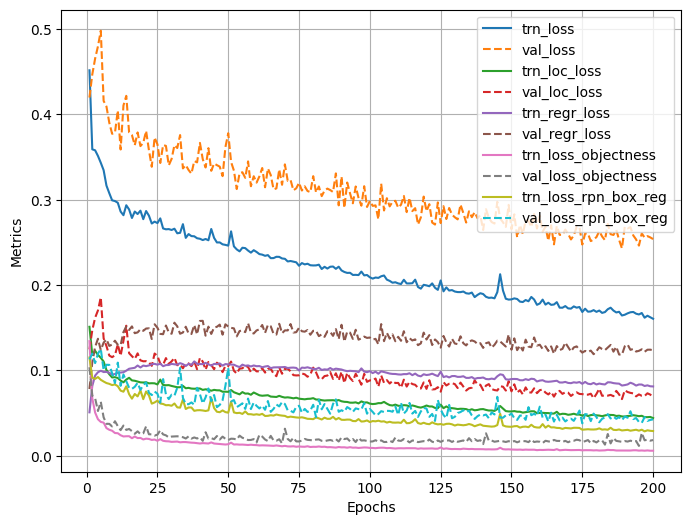

In [ ]:
# load log file
# Change path directory 
log = pickle.load(open(r"D:\FinalProject_ENSF619\Checkpoints-v3\log_report 199.pkl", 'rb'))
log.plot_epochs(['trn_loss', 'val_loss', 'trn_loc_loss', 'val_loc_loss', 'trn_regr_loss', 'val_regr_loss', 'trn_loss_objectness', 'val_loss_objectness', 'trn_loss_rpn_box_reg', 'val_loss_rpn_box_reg'])

### Testing our Model

In [ ]:
model_eval = FasterRCNN(backbone=backbone, num_classes=num_classes)
in_features = model_eval.roi_heads.box_predictor.cls_score.in_features
model_eval.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
# print(model_eval)

# Load the model state from the checkpoint
model_state = torch.load(r"D:\FinalProject_ENSF619\Checkpoints-v3\ckpt 199.pth")
model_eval.load_state_dict(model_state)

# to torch and float
model_eval = model_eval.to(device).float()
model_eval.eval()

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=1e-05)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=1e-05)
          (relu): ReLU(inplace=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=1e-05)
        )
        (1): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride

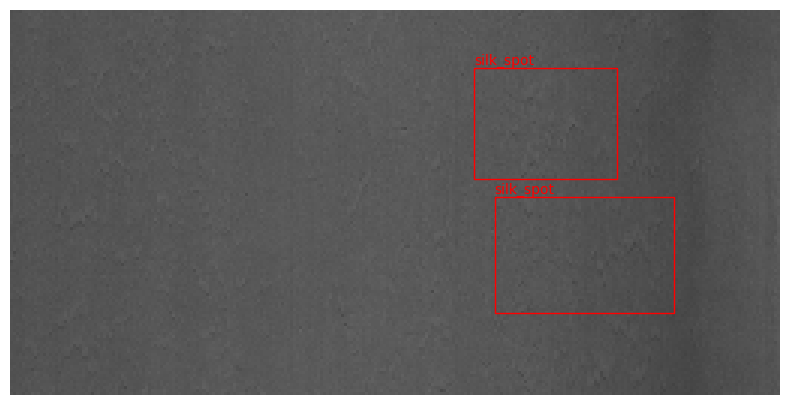

In [ ]:
# test one sample image
image_tensor, target = test_ds[136]  # Assuming dataset is defined
show_image(image_tensor.permute(1, 2, 0), target['boxes'], [targets2label[i.item()] for i in target['labels']])

tensor([6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6], device='cuda:0') tensor([0.7860, 0.6564, 0.6396, 0.5697, 
0.4813, 0.4539, 0.4346, 0.1665, 0.1462,
        0.1387, 0.1018, 0.0912, 0.0751, 0.0720, 0.0690, 0.0610],
       device='cuda:0', grad_fn=<IndexBackward0>)

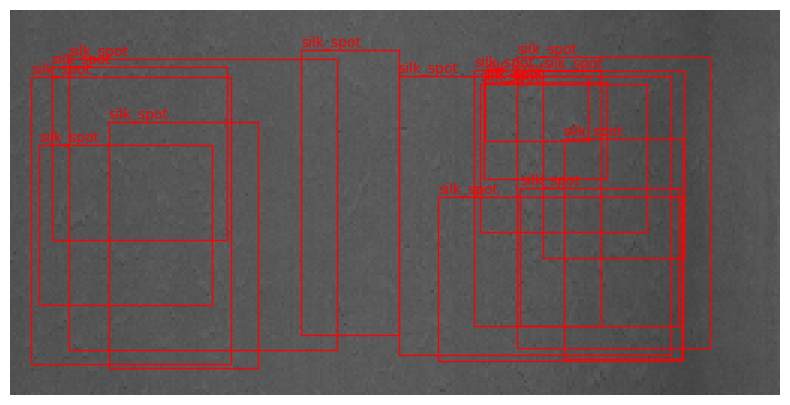

In [ ]:
predictions = model_eval([image_tensor.to(device).float()])
print(predictions[0]["labels"], predictions[0]["scores"])


image_tensor = image_tensor.cpu()
# convert predictions to cpu using detch numpy
predictions[0]["boxes"] = predictions[0]["boxes"].cpu().detach().numpy()
predictions[0]["labels"] = predictions[0]["labels"].cpu().detach().numpy()
predictions[0]["scores"] = predictions[0]["scores"].cpu().detach().numpy()

# show the image with the predictions
show_image(image_tensor.permute(1,2,0), predictions[0]['boxes'], [targets2label[i.item()] for i in predictions[0]['labels']])

### NMS

In [412]:
def calculate_iou(box1, box2):
    # Calculate intersection coordinates
    x1 = max(box1[0], box2[0])
    y1 = max(box1[1], box2[1])
    x2 = min(box1[2], box2[2])
    y2 = min(box1[3], box2[3])

    # Calculate intersection area
    intersection_area = max(0, x2 - x1) * max(0, y2 - y1)

    # Calculate union area
    box1_area = (box1[2] - box1[0]) * (box1[3] - box1[1])
    box2_area = (box2[2] - box2[0]) * (box2[3] - box2[1])
    union_area = box1_area + box2_area - intersection_area

    # Calculate IoU
    iou = intersection_area / union_area

    return iou
# prediction = {'boxes': [(100, 100, 200, 200)], 'labels': [1], 'scores': [0.9]}  # Example prediction
# target = {'boxes': [(90, 90, 210, 210)], 'labels': [1]}  # Example target
# iou = calculate_iou(prediction['boxes'][0], target['boxes'][0])
# print("IoU:", iou)

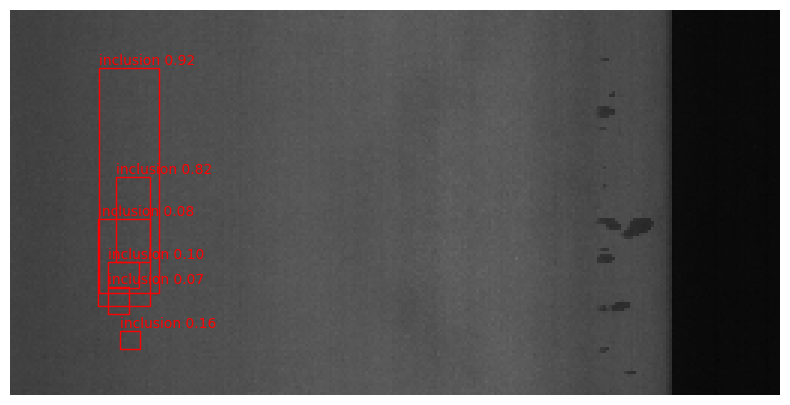

In [632]:
def nms(bboxes, labels, scores, iou_threshold=0.3, prob_threshold=0.5):
    # find the indices of the boxes which have a probability higher than the threshold
    # kept_indices = scores > prob_threshold
    # bboxes = bboxes[kept_indices]
    # labels = labels[kept_indices]
    # scores = scores[kept_indices]

    # sort the boxes by their scores
    sorted_indices = np.argsort(scores)[::-1]
    bboxes = bboxes[sorted_indices]
    labels = labels[sorted_indices]
    scores = scores[sorted_indices]

    # list to store the indices of the boxes to keep
    keep_indices = [True] * len(sorted_indices)
    bboxes_to_keep = []
    labels_to_keep = []
    scores_to_keep = []

    while len(sorted_indices) > 0:
        # print("All boxes", bboxes, labels, scores)
        # print("Sorted indices", sorted_indices)
        # print("Kept boxes", bboxes_to_keep, labels_to_keep, scores_to_keep)
        keep_indices = [True] * len(sorted_indices)
        current_index = sorted_indices[0]
        keep_indices[0] = False
        current_box = bboxes[current_index]
        current_label = labels[current_index]
        current_score = scores[current_index]

        # print(sorted_indices, current_label, current_score)

        for i in range(1, len(sorted_indices)):
            if labels[i] == current_label:
                iou = calculate_iou(current_box, bboxes[sorted_indices[i]])
                # print(iou, current_box, bboxes[sorted_indices[i]])
                if iou > iou_threshold:
                    keep_indices[i] = False

        sorted_indices = sorted_indices[keep_indices]
        bboxes_to_keep.append(current_box)
        labels_to_keep.append(current_label)
        scores_to_keep.append(current_score)

    return bboxes_to_keep, labels_to_keep, scores_to_keep

# # print(predictions[0]['boxes'], predictions[0]['labels'], predictions[0]['scores'])
kept_predictions = nms(predictions[0]['boxes'], predictions[0]['labels'], predictions[0]['scores'])
# print(kept_predictions)
# # print(kept_predictions[2])
show_image(image_tensor.permute(1, 2, 0), kept_predictions[0], [f"{targets2label[item]} {kept_predictions[2][index]:0.2f}" for index, item in enumerate(kept_predictions[1])])

In [633]:
def show_image_labels(image, gt_boxes=None, gt_labels=None, pred_boxes=None, pred_labels=None, ax=None):
    if ax is None:
        fig, ax = plt.subplots(figsize=(6,3))

    ax.imshow(image, cmap="gray")

    if gt_boxes is not None and gt_labels is not None:
        for box, label in zip(gt_boxes, gt_labels):
                x, y, xmax, ymax = box
                w = xmax - x
                h = ymax - y
                rect = patches.Rectangle((x, y), w, h, linewidth=1, edgecolor='g', facecolor='none')
                ax.add_patch(rect)
                ax.text(x, y, label, color='g', verticalalignment='bottom', fontsize=13,
                        bbox=dict(facecolor='w', alpha=0.8))

    if pred_boxes is not None and pred_labels is not None:
        for box, label in zip(pred_boxes, pred_labels):
                x, y, xmax, ymax = box
                w = xmax - x
                h = ymax - y
                rect = patches.Rectangle((x, y), w, h, linewidth=1, edgecolor='r', facecolor='none')
                ax.add_patch(rect)
                ax.text(x, y, label, color='r', verticalalignment='bottom', fontsize=13,
                        bbox=dict(facecolor='w', alpha=0.8))

    ax.axis('on')
    ax.grid(True)
    if ax is None:
        plt.show()

In [634]:
# find all ground truth boxes for test
from tqdm import tqdm

all_targets = []
all_predictions = []

for testIndex, batch in tqdm(enumerate(test_dl)):
    imgs, targets = batch

    for dataIndex in range(BATCH_SIZE):
        if testIndex*BATCH_SIZE + dataIndex >= len(test_ds):
            break
        for boxIndex in range(len(targets[dataIndex]['labels'])):
            all_targets.append([
                testIndex*BATCH_SIZE + dataIndex,
                targets[dataIndex]['labels'][boxIndex].item(),
                targets[dataIndex]['boxes'][boxIndex].tolist(),
            ])

    imgs = [img.to(device).float() for img in imgs]
    targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
    predictions = model_eval([img.to(device).float() for img in imgs])
    for index, prediction in enumerate(predictions):
      prediction["boxes"] = prediction["boxes"].cpu().detach().numpy()
      prediction["labels"] = prediction["labels"].cpu().detach().numpy()
      prediction["scores"] = prediction["scores"].cpu().detach().numpy()
      kept_prediction = nms(prediction['boxes'], prediction['labels'], prediction['scores'])
      for boxIndex in range(len(kept_prediction[0])):
        all_predictions.append([
            testIndex*BATCH_SIZE + index,
            kept_prediction[1][boxIndex],
            kept_prediction[2][boxIndex],
            kept_prediction[0][boxIndex].tolist(),
        ])

13it [00:10,  1.22it/s]


In [635]:
print(all_predictions[0],
      all_targets[0],
      len(all_targets),
      len(all_predictions))

[0, 7, 0.93062496, [165.918701171875, 47.67012405395508, 174.07273864746094, 55.55812072753906]]
[0, 7, [165.25, 45.82400131225586, 175.0, 56.832000732421875]]
386 1039

In [636]:
from collections import Counter

def calculate_average_precision(pred_boxes, target_boxes, class_id, iou_threshold=0.5):
  epsilon = 1e-6
  detections = []
  targets = []

  for detection in pred_boxes:
    if detection[1] == class_id:
      detections.append(detection)

  for target in target_boxes:
    if target[1] == class_id:
      targets.append(target)

  # calculate the tp and fp based on predictions
  amount_boxes = Counter([target[0] for target in targets])

  for key,value in amount_boxes.items():
    amount_boxes[key] = torch.zeros(value)

  
  before_sort_detection = detections.copy()
  detections.sort(key=lambda x: x[2], reverse=True)
  TP = torch.zeros((len(detections)))
  FP = torch.zeros((len(detections)))
  total_true_bbs = len(targets)

  for detection_idx, detection in enumerate(detections):
    gt_imgs = [
        bbox for bbox in targets if bbox[0] == detection[0]
    ]

    num_gts = len(gt_imgs)
    best_iou = 0
    best_gt_idx = 0

    for gt_idx, gt in enumerate(gt_imgs):
      
      iou = calculate_iou(
          torch.tensor(detection[3]),
          torch.tensor(gt[2])
      )

      if iou > best_iou:
        best_iou = iou
        best_gt_idx = gt_idx

    if best_iou > iou_threshold:
      if amount_boxes[detection[0]][best_gt_idx] == 0:
        TP[detection_idx] = 1
        amount_boxes[detection[0]][best_gt_idx] = 1
      else:
          FP[detection_idx] = 1
    else:
      FP[detection_idx] = 1

  TP_cumsum = torch.cumsum(TP, dim=0)
  FP_cumsum = torch.cumsum(FP, dim=0)

  recalls = TP_cumsum / (total_true_bbs + epsilon)
  precisions = torch.divide(TP_cumsum, (TP_cumsum + FP_cumsum + epsilon))

  precisions = torch.cat((torch.tensor([1]), precisions))
  recalls = torch.cat((torch.tensor([0]), recalls))

  average_precisions = torch.trapz(precisions, recalls)

  final_recall = recalls[-1].item()

  # find the id of FP on before sort detection
  id_list = []
  for idx in range(len(FP)):
    if FP[idx] == 1:
      for idx2 in range(len(FP)):
        if before_sort_detection[idx2] == detections[idx]:
          id_list.append(before_sort_detection[idx2][0])
          break

  return precisions, recalls, average_precisions, final_recall

In [637]:
class_precision, class_recall, class_average_precision, class_final_recall = calculate_average_precision(all_predictions, all_targets, 6, 0.5)

Recalls: [0.9643, 0.98, 0.96, 0.7742, 0.9691, 0.7671, 0.7069, 1.0, 0.75, 0.8571]

Average Precisions: 0.7626630067825317

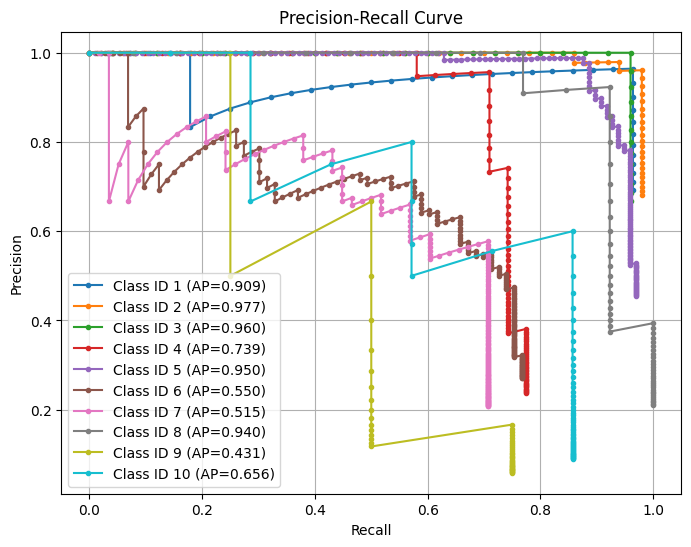

In [638]:
plt.figure(figsize=(8, 6))
recalls_res = []
average_precisions_res = []

for id in range(1, num_classes):
  precisions, recalls, average_precisions, recall = calculate_average_precision(all_predictions, all_targets, id)
  recalls_res.append(round(recall,4))
  average_precisions_res.append(average_precisions)
  plt.plot(recalls, precisions, marker='.', label=f'Class ID {id} (AP={average_precisions.item():.3f})')

print(f"Recalls: {recalls_res}")
mAP = sum(average_precisions_res) / len(average_precisions_res)
print(f"Average Precisions: {mAP}")
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()

plt.grid(True)
plt.show()

In [639]:
def calculate_mean_average_precision(pred_boxes, true_boxes, num_classes=11, iou_threshold=0.5):
  average_precisions = []

  for id in range(1,num_classes):
    _, _, average_precision, _ = calculate_average_precision(pred_boxes, true_boxes, id, iou_threshold)
    average_precisions.append(average_precision)

  return sum(average_precisions) / len(average_precisions)

results = []
for thr in np.arange(0.5,0.9,0.05):
  result = calculate_mean_average_precision(all_predictions, all_targets, iou_threshold=thr)
  results.append(result)
print(results)
print(sum(results)/len(results))

[
    tensor(0.7627),
    tensor(0.7376),
    tensor(0.6698),
    tensor(0.6245),
    tensor(0.5049),
    tensor(0.4065),
    tensor(0.2422),
    tensor(0.0910)
]

tensor(0.5049)

In [504]:
def test_batch_images(batch_num):

  #generate 3 random number between 0 and len(test_ds)
  random_list = random.sample(range(0, len(test_ds)), batch_num)
  print(random_list)
  random_list = [1, 50, 24, 4]
  
  for i in range(len(random_list)):
    image_tensor, target = test_ds[random_list[i]]
    predictions = model_eval([image_tensor.to(device).float()])
    image_tensor = image_tensor.cpu()
    predictions[0]["boxes"] = predictions[0]["boxes"].cpu().detach().numpy()
    predictions[0]["labels"] = predictions[0]["labels"].cpu().detach().numpy()
    predictions[0]["scores"] = predictions[0]["scores"].cpu().detach().numpy()
    kept_predictions = nms(predictions[0]['boxes'], predictions[0]['labels'], predictions[0]['scores'])
    show_image_labels(image_tensor.permute(1, 2, 0),
              target['boxes'], [targets2label[i.item()] for i in target['labels']],
              kept_predictions[0], [f"{targets2label[item]} {kept_predictions[2][index]:0.2f}" for index, item in enumerate(kept_predictions[1])])

[166, 59, 20, 133]

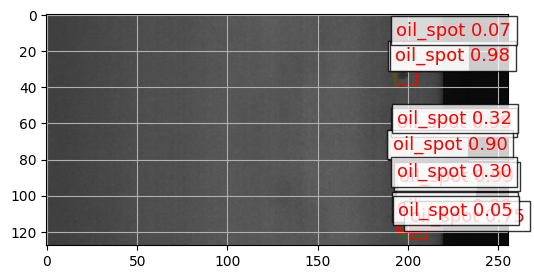

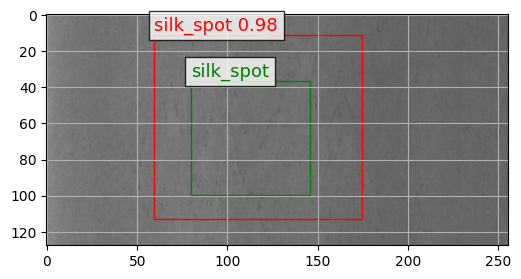

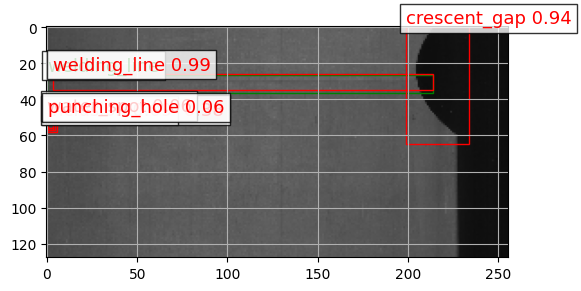

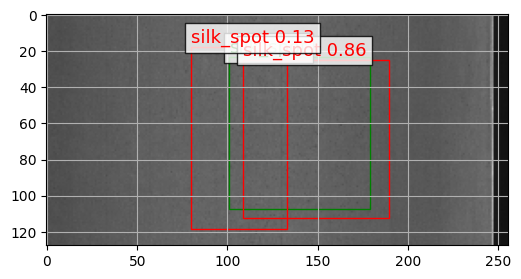

In [505]:
test_batch_images(4)

### Soft NMS

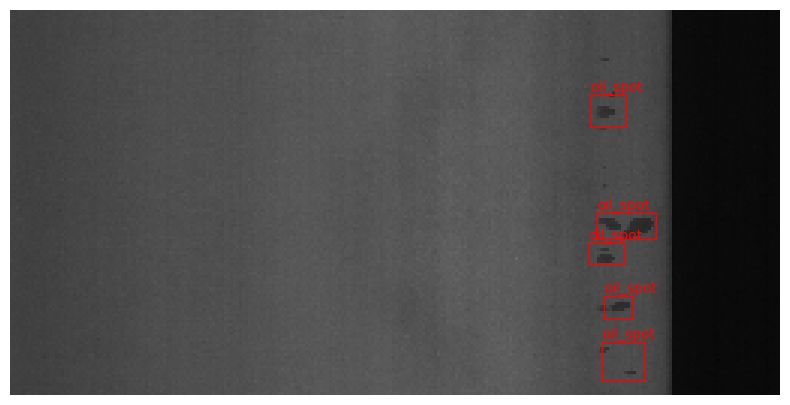

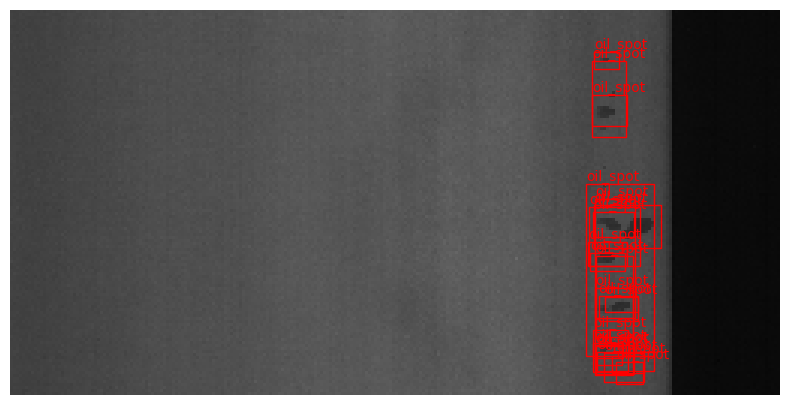

In [601]:
# test one sample image
image_tensor, target = test_ds[1]  # Assuming dataset is defined
show_image(image_tensor.permute(1, 2, 0), target['boxes'], [targets2label[i.item()] for i in target['labels']])

predictions = model_eval([image_tensor.to(device).float()])

image_tensor = image_tensor.cpu()
predictions[0]["boxes"] = predictions[0]["boxes"].cpu().detach().numpy()
predictions[0]["labels"] = predictions[0]["labels"].cpu().detach().numpy()
predictions[0]["scores"] = predictions[0]["scores"].cpu().detach().numpy()

# show the image with the predictions
show_image(image_tensor.permute(1,2,0), predictions[0]['boxes'], [targets2label[i.item()] for i in predictions[0]['labels']])

{
    'labels': tensor([5, 5, 5, 5, 5]),
    'boxes': tensor([[192.2500,  27.6480, 204.3750,  38.2720],
        [194.6250,  66.9440, 214.1250,  75.7760],
        [192.0000,  76.9280, 203.8750,  83.8400],
        [197.0000,  94.7200, 206.7500, 102.2720],
        [196.3750, 109.8240, 210.7500, 123.0080]])
}

10

[0.9872851  0.9609623  0.87653184 0.5991204  0.51448214 0.4586919
 0.1638119  0.1584209  0.06719997 0.06186052]

6

(
    [
        array([194.89104,  50.15017, 211.96686,  65.27698], dtype=float32),
        array([203.25449,  80.55433, 211.69846,  88.0419 ], dtype=float32),
        array([194.3613  , 109.046974, 204.01857 , 119.91345 ], dtype=float32),
        array([193.35815 ,  39.19731 , 213.14676 ,  64.602974], dtype=float32),
        array([200.61891 ,  35.886845, 210.09518 ,  49.082825], dtype=float32),
        array([199.26485,  79.68792, 213.06651,  88.90972], dtype=float32)
    ],
    [5, 5, 5, 5, 5, 5],
    [0.9872851, 0.9609623, 0.5991204, 0.59712136, 0.43576786, 0.34100208]
)

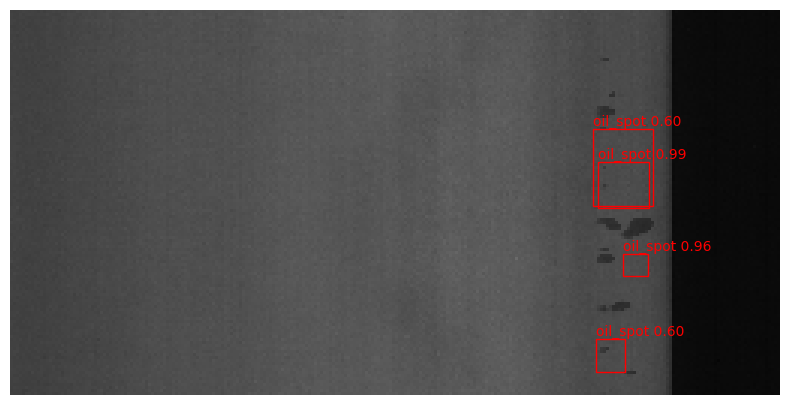

In [640]:
def soft_nms(bboxes, labels, scores, sigma=0.6, floating_threshold=0.1, prob_threshold=0.5):
    # kept_indices = scores > prob_threshold
    # bboxes = bboxes[kept_indices]
    # labels = labels[kept_indices]
    # scores = scores[kept_indices]

    # Sort the boxes, labels, and scores based on scores in descending order
    sorted_indices = np.argsort(scores)[::-1]
    bboxes = bboxes[sorted_indices]
    labels = labels[sorted_indices]
    scores = scores[sorted_indices]

    # Initialize lists to store the boxes, labels, and scores to keep
    bboxes_to_keep = []
    labels_to_keep = []
    scores_to_keep = []

    while len(scores) > 0:
        # Select the first box as it has the highest score
        current_box = bboxes[0]
        current_label = labels[0]
        current_score = scores[0]

        # Add the current box to the keep lists
        bboxes_to_keep.append(current_box)
        labels_to_keep.append(current_label)
        scores_to_keep.append(current_score)

        # If there is only one box left, break from the loop
        if len(scores) == 1:
            break

        # Calculate IoU of the current box with all other boxes
        iou = np.array([calculate_iou(current_box, box) for box in bboxes[1:]])

        # Apply Soft-NMS formula to update scores
        scores[1:] = scores[1:] * np.exp(-(iou**2) / sigma)

        keep_mask = scores[1:] > floating_threshold
        keep_mask = np.insert(keep_mask, 0, False)

        # Apply the keep mask to boxes, labels, and scores
        bboxes = bboxes[keep_mask]
        labels = labels[keep_mask]
        scores = scores[keep_mask]

        sorted_indices = np.argsort(scores)[::-1]
        bboxes = bboxes[sorted_indices]
        labels = labels[sorted_indices]
        scores = scores[sorted_indices]

    return bboxes_to_keep, labels_to_keep, scores_to_keep

print(target)
print(len(predictions[0]['boxes']))
print(predictions[0]['scores'])
kept_predictions = soft_nms(predictions[0]['boxes'], predictions[0]['labels'], predictions[0]['scores'])
# show_image_labels(image_tensor.permute(1, 2, 0),
#             target['boxes'], [targets2label[i.item()] for i in target['labels']],
#             kept_predictions[0], [f"{targets2label[item]} {kept_predictions[2][index]:0.2f}" for index, item in enumerate(kept_predictions[1])])
print(len(kept_predictions[0]))
print(kept_predictions)
scores = kept_predictions[2]
filtered_indices = [i for i, score in enumerate(scores) if score > 0.5]
boxes = np.array(kept_predictions[0])[filtered_indices]
labels = [kept_predictions[1][i] for i in filtered_indices]
show_image(image_tensor.permute(1, 2, 0), boxes, [f"{targets2label[item]} {scores[index]:0.2f}" for index, item in enumerate(labels)])

In [641]:
# find all ground truth boxes for test
from tqdm import tqdm

all_targets_soft = []
all_predictions_soft = []

for testIndex, batch in tqdm(enumerate(test_dl)):
    imgs, targets = batch

    for dataIndex in range(BATCH_SIZE):
        if testIndex*BATCH_SIZE + dataIndex >= len(test_ds):
            break
        for boxIndex in range(len(targets[dataIndex]['labels'])):
            all_targets_soft.append([
                testIndex*BATCH_SIZE + dataIndex,
                targets[dataIndex]['labels'][boxIndex].item(),
                targets[dataIndex]['boxes'][boxIndex].tolist(),
            ])

    imgs = [img.to(device).float() for img in imgs]
    targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
    predictions = model_eval([img.to(device).float() for img in imgs])
    for index, prediction in enumerate(predictions):
      prediction["boxes"] = prediction["boxes"].cpu().detach().numpy()
      prediction["labels"] = prediction["labels"].cpu().detach().numpy()
      prediction["scores"] = prediction["scores"].cpu().detach().numpy()
      kept_prediction = soft_nms(prediction['boxes'], prediction['labels'], prediction['scores'])
      for boxIndex in range(len(kept_prediction[0])):
        all_predictions_soft.append([
            testIndex*BATCH_SIZE + index,
            kept_prediction[1][boxIndex],
            kept_prediction[2][boxIndex],
            kept_prediction[0][boxIndex].tolist(),
        ])

13it [00:10,  1.27it/s]


In [642]:
print(all_predictions_soft[0],
      all_targets_soft[0],
      len(all_targets_soft),
      len(all_predictions_soft))

[0, 7, 0.97680116, [117.91819763183594, 78.05435180664062, 125.87932586669922, 84.78729248046875]]
[0, 7, [94.75, 42.11199951171875, 107.625, 51.071998596191406]]
386 1049

Recalls: [0.9643, 0.98, 1.0, 0.8387, 0.9794, 0.8904, 0.7759, 0.9231, 0.75, 1.0]

Average Precisions: 0.7648681998252869

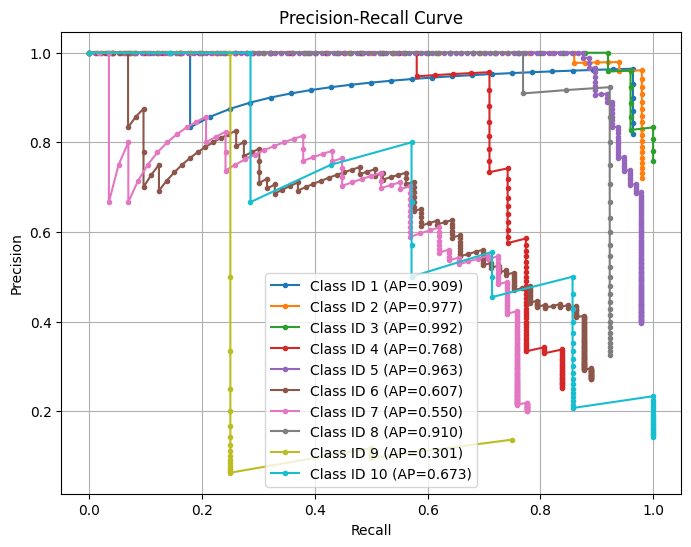

In [643]:
plt.figure(figsize=(8, 6))
recalls_res = []
average_precisions_res = []

for id in range(1, num_classes):
  precisions, recalls, average_precisions, recall = calculate_average_precision(all_predictions_soft, all_targets_soft, id)
  recalls_res.append(round(recall,4))
  average_precisions_res.append(average_precisions)
  plt.plot(recalls, precisions, marker='.', label=f'Class ID {id} (AP={average_precisions.item():.3f})')

print(f"Recalls: {recalls_res}")
mAP = sum(average_precisions_res) / len(average_precisions_res)
print(f"Average Precisions: {mAP}")
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()

plt.grid(True)
plt.show()

In [644]:
def calculate_mean_average_precision(pred_boxes, true_boxes, num_classes=11, iou_threshold=0.5):
  average_precisions = []

  for id in range(1,num_classes):
    _, _, average_precision, _ = calculate_average_precision(pred_boxes, true_boxes, id, iou_threshold)
    average_precisions.append(average_precision)

  return sum(average_precisions) / len(average_precisions)

results = []
for thr in np.arange(0.5,0.9,0.05):
  result = calculate_mean_average_precision(all_predictions_soft, all_targets_soft, iou_threshold=thr)
  results.append(result)
print(results)
print(sum(results)/len(results))

[
    tensor(0.7649),
    tensor(0.7424),
    tensor(0.6867),
    tensor(0.6391),
    tensor(0.5199),
    tensor(0.4146),
    tensor(0.2470),
    tensor(0.0924)
]

tensor(0.5134)

In [611]:
def test_batch_images(batch_num):

  #generate 3 random number between 0 and len(test_ds)
  random_list = random.sample(range(0, len(test_ds)), batch_num)
  print(random_list)
  # random_list = [1, 50, 24, 4]
  
  for i in range(len(random_list)):
    image_tensor, target = test_ds[random_list[i]]
    predictions = model_eval([image_tensor.to(device).float()])
    image_tensor = image_tensor.cpu()
    predictions[0]["boxes"] = predictions[0]["boxes"].cpu().detach().numpy()
    predictions[0]["labels"] = predictions[0]["labels"].cpu().detach().numpy()
    predictions[0]["scores"] = predictions[0]["scores"].cpu().detach().numpy()
    kept_predictions = soft_nms(predictions[0]['boxes'], predictions[0]['labels'], predictions[0]['scores'])
    scores = kept_predictions[2]
    filtered_indices = [i for i, score in enumerate(scores) if score > 0.6]
    boxes = np.array(kept_predictions[0])[filtered_indices]
    labels = [kept_predictions[1][i] for i in filtered_indices]
    show_image_labels(image_tensor.permute(1, 2, 0),
              target['boxes'], [targets2label[i.item()] for i in target['labels']],
              boxes, [f"{targets2label[item]} {scores[index]:0.2f}" for index, item in enumerate(labels)])

[106, 48, 47, 33]

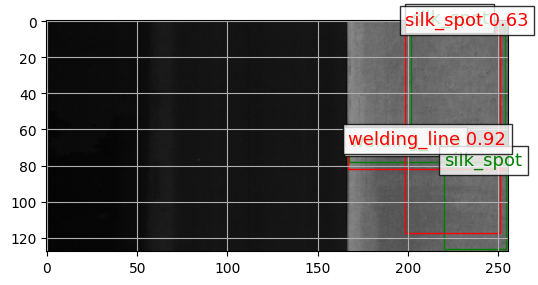

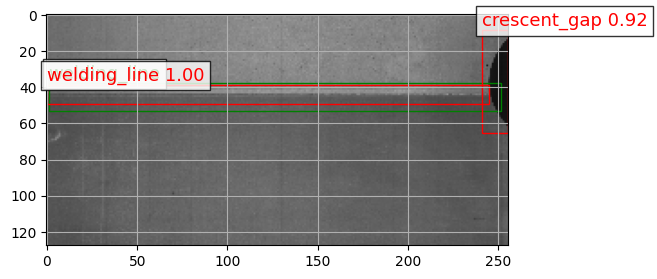

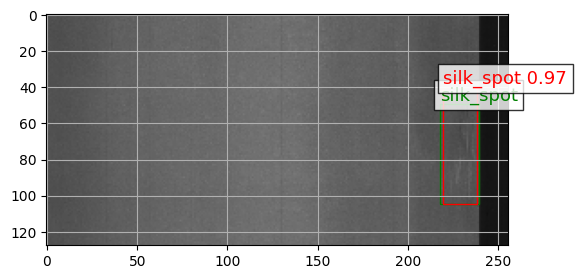

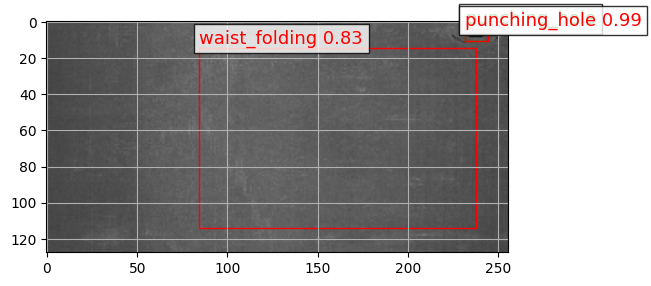

In [613]:
test_batch_images(4)